In [ ]:
# MIXED MM -> Latent Profile Analysis

In [ ]:
#!pip3 install pandas

In [ ]:
#!pip3 install seaborn

In [ ]:
## Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, ParameterGrid
from stepmix.bootstrap import blrt_sweep
from stepmix.stepmix import StepMix
from stepmix.utils import get_mixed_descriptor

In [ ]:
# Load data 

# MEASUREMENT MODEL

# CONTINUOUS + BINARY MM
cnt = pd.read_csv('../data/Xcnt_std.csv', index_col=0)

# Define MIXED descriptor for MM
# (unspecified variables are simply not included in mixed_data)
X_mixed, mixed_descriptor = get_mixed_descriptor(
    dataframe = cnt,
    continuous = ['rel_cnt', 'rel_clo'], # can also deal with continuous NaN!!
    binary_nan = ['tra_lca', 'cnf_lca', 'sup_lca', 'mon_lca']
)

In [7]:
X_mixed

,rel_cnt,rel_clo,tra_lca,cnf_lca,sup_lca,mon_lca
1,1.0,1.00,1.0,0,1,1
2,1.0,1.00,1.0,0,1,1
3,0.6,0.75,1.0,0,0,0
4,0.8,0.75,0.0,0,0,0
5,0.8,1.00,1.0,0,1,1
...,...,...,...,...,...,...
63668,0.8,0.75,0.0,1,0,0
63669,0.8,0.75,0.0,1,0,0
63670,0.8,0.75,0.0,1,1,1
63671,0.8,0.75,0.0,1,1,0


In [ ]:
# Load data 

# STRUCTURAL MODEL
Z = pd.read_csv('../data/Z.csv', index_col = 0)

# The covariate model as an internal optimization procedure
# We can specify additional arguments such as the learning rate
# and the optimization method
opt_params = {
    'method': 'newton-raphson',  # Can also be "gradient",
    'intercept': True,
    'max_iter': 1,  # Number of opt. step each time we update the covariate model
}

In [ ]:
# Set ups
k = 5  # number of classes
m = 3000 # maximum number iterations
r = 5 # number of times to estimate models (nrep > 1 automates search for global max)

# random seed
seed = 240792

In [ ]:
# Define base model for MIXED w/o covariates (1-step)
mixed_base1 = StepMix(
    n_components = 5, 
    n_steps = 1,
    measurement = mixed_descriptor,   
    verbose = 1, 
    n_init = r,
    max_iter = m,
    random_state = seed)

mixed_base1.fit(X_mixed)

In [ ]:
# Define base model for MIXED w/o covariates (2-step)
mixed_base2 = StepMix(
    n_components = 5, 
    n_steps = 2,
    measurement = mixed_descriptor,   
    verbose = 1, 
    n_init = r,
    max_iter = m,
    random_state = seed)

mixed_base2.fit(X_mixed)

In [ ]:
# Define base model for MIXED w/o covariates (3-step, ML)
mixed_base3ml = StepMix(
    n_components = 5, 
    n_steps = 3,
    correction = 'ML',
    measurement = mixed_descriptor,   
    verbose = 1, 
    n_init = r,
    max_iter = m,
    random_state = seed)

mixed_base3ml.fit(X_mixed)

In [ ]:
# COMPARE: MM with and without covariates (3-step)

# Define model for MIXED with covariates (3-step, ML)
mixed_cov3ml = StepMix(
    n_components = 5, 
    n_steps = 3,
    correction = 'ML',
    measurement = mixed_descriptor,   
    structural = 'covariate', 
    structural_params = opt_params,
    verbose = 1, 
    n_init = r,
    max_iter = m,
    random_state = seed)

mixed_cov3ml.fit(X_mixed, Z)

In [8]:
# HOW MANY CLASSES? -- MIXED 

# Loop over number of classes (3-step ML)
result_mixed_numcl = dict(number=[], log_likelihood=[], caic=[], abic=[], relative_entropy=[])

for n in [1, 2, 3, 4, 5, 6, 7, 8]:
    # Create a new StepMix instance for each n
    mixed_base3ml = StepMix(
        n_components=n, 
        n_steps=3,
        correction='ML',
        measurement=mixed_descriptor,   
        verbose=1, 
        n_init=r,
        max_iter=m,
        random_state=seed
    )
    
    # Fit the model
    mixed_base3ml.fit(X_mixed)
    
    # Get log-likelihood
    ll = mixed_base3ml.score(X_mixed)

    # Get cAIC
    caic = mixed_base3ml.caic(X_mixed)

    # Get sBIC
    abic = mixed_base3ml.sabic(X_mixed)

    # Get relative entropy
    rel_entr = mixed_base3ml.relative_entropy(X_mixed)
    
    # Store results
    result_mixed_numcl['number'].append(n)
    result_mixed_numcl['log_likelihood'].append(ll)
    result_mixed_numcl['caic'].append(caic)
    result_mixed_numcl['abic'].append(abic)
    result_mixed_numcl['relative_entropy'].append(rel_entr)


Fitting StepMix...


Initializations (n_init) : 100%|████████████████| 5/5 [00:00<00:00, 36.21it/s, max_LL=-1.73e+5, max_avg_LL=-2.72]

MODEL REPORT
    Measurement model parameters
          model_name           continuous
          class_no                      0
          param       variable           
          covariances rel_clo      0.1250
                      rel_cnt      0.1089
          means       rel_clo      0.4215
                      rel_cnt      0.3996


          model_name     binary_nan
          class_no                0
          param variable           
          pis   cnf_lca      0.2484
                mon_lca      0.0856
                sup_lca      0.3219
                tra_lca      0.3293


    Class weights
        Class 1 : 1.00
    Fit for 1 latent classes
    Estimation method             : 3-step
    Correction method             : ML
    Assignment method             : modal
    Number of observations        : 63672
    Number of latent classes      : 1
    Number of estimated parameters: 8
    Log-likelihood (LL)           : -173493.5625
    -2LL                          : 346987.

Fitting StepMix...


Initializations (n_init) : 100%|█████████████████| 5/5 [00:07<00:00,  1.53s/it, max_LL=-1.21e+5, max_avg_LL=-1.9]


MODEL REPORT
    Measurement model parameters
          model_name           continuous        
          class_no                      0       1
          param       variable                   
          covariances rel_clo      0.0541  0.0381
                      rel_cnt      0.0641  0.0248
          means       rel_clo      0.7517  0.1787
                      rel_cnt      0.7025  0.1769


          model_name     binary_nan        
          class_no                0       1
          param variable                   
          pis   cnf_lca      0.2917  0.2165
                mon_lca      0.1948  0.0054
                sup_lca      0.6786  0.0596
                tra_lca      0.5089  0.1713


    Class weights
        Class 1 : 0.42
        Class 2 : 0.58
    Fit for 2 latent classes
    Estimation method             : 3-step
    Correction method             : ML
    Assignment method             : modal
    Number of observations        : 63672
    Number of latent classes     

Initializations (n_init) : 100%|████████████████| 5/5 [00:16<00:00,  3.30s/it, max_LL=-1.05e+5, max_avg_LL=-1.65]


MODEL REPORT
    Measurement model parameters
          model_name           continuous                
          class_no                      0       1       2
          param       variable                           
          covariances rel_clo      0.0575  0.0148  0.0120
                      rel_cnt      0.0480  0.0139  0.0070
          means       rel_clo      0.5446  0.0869  0.9391
                      rel_cnt      0.4677  0.1137  0.9551


          model_name     binary_nan                
          class_no                0       1       2
          param variable                           
          pis   cnf_lca      0.2491  0.2236  0.3122
                mon_lca      0.0643  0.0028  0.3716
                sup_lca      0.3883  0.0247  0.9127
                tra_lca      0.3581  0.1324  0.6513


    Class weights
        Class 1 : 0.45
        Class 2 : 0.40
        Class 3 : 0.15
    Fit for 3 latent classes
    Estimation method             : 3-step
    Correction method

Initializations (n_init) : 100%|█████████████████| 5/5 [00:12<00:00,  2.41s/it, max_LL=1.29e+4, max_avg_LL=0.203]


MODEL REPORT
    Measurement model parameters
          model_name           continuous                        
          class_no                      0       1       2       3
          param       variable                                   
          covariances rel_clo      0.0137  0.0424  0.0494  0.0000
                      rel_cnt      0.0187  0.0000  0.0357  0.0181
          means       rel_clo      0.3275  0.8762  0.6852  0.0000
                      rel_cnt      0.2441  1.0000  0.5512  0.0962


          model_name     binary_nan                        
          class_no                0       1       2       3
          param variable                                   
          pis   cnf_lca      0.1805  0.3560  0.2593  0.2540
                mon_lca      0.0047  0.3565  0.1125  0.0065
                sup_lca      0.0863  0.8430  0.5678  0.0354
                tra_lca      0.1901  0.6755  0.4150  0.1477


    Class weights
        Class 1 : 0.29
        Class 2 : 0.13
    

Initializations (n_init) : 100%|███████████████████| 5/5 [00:28<00:00,  5.72s/it, max_LL=1.46e+5, max_avg_LL=2.3]


MODEL REPORT
    Measurement model parameters
          model_name           continuous                             
          class_no                      0       1       2    3       4
          param       variable                                        
          covariances rel_clo      0.0131  0.0000  0.0000  0.0  0.0000
                      rel_cnt      0.0559  0.0546  0.0248  0.0  0.0360
          means       rel_clo      0.8243  0.5000  0.0000  1.0  0.2500
                      rel_cnt      0.6247  0.4367  0.1050  1.0  0.2713


          model_name     binary_nan                                
          class_no                0       1       2       3       4
          param variable                                           
          pis   cnf_lca      0.2510  0.2480  0.2578  0.2661  0.2273
                mon_lca      0.1459  0.0548  0.0085  0.3998  0.0227
                sup_lca      0.6373  0.3285  0.0384  0.9205  0.1188
                tra_lca      0.4393  0.3324  0.

Initializations (n_init) : 100%|██████████████████| 5/5 [00:11<00:00,  2.23s/it, max_LL=1.92e+5, max_avg_LL=3.02]


MODEL REPORT
    Measurement model parameters
          model_name           continuous                                      
          class_no                      0       1       2     3       4       5
          param       variable                                                 
          covariances rel_clo      0.0000  0.0000  0.0000  0.00  0.0000  0.0000
                      rel_cnt      0.0360  0.0546  0.0487  0.00  0.0370  0.0248
          means       rel_clo      0.2500  0.5000  1.0000  0.75  0.7500  0.0000
                      rel_cnt      0.2713  0.4368  0.8452  1.00  0.5322  0.1050


          model_name     binary_nan                                        
          class_no                0       1       2       3       4       5
          param variable                                                   
          pis   cnf_lca      0.2273  0.2481  0.2400  0.4801  0.2211  0.2578
                mon_lca      0.0227  0.0549  0.3057  0.2997  0.0938  0.0085
            

Initializations (n_init) : 100%|██████████████████| 5/5 [00:12<00:00,  2.45s/it, max_LL=2.12e+5, max_avg_LL=3.34]


MODEL REPORT
    Measurement model parameters
          model_name           continuous                                             
          class_no                      0    1       2       3       4       5       6
          param       variable                                                        
          covariances rel_clo      0.0000  0.0  0.0000  0.0000  0.0000  0.0158  0.0000
                      rel_cnt      0.0546  0.0  0.0639  0.0371  0.0182  0.0093  0.0294
          means       rel_clo      0.5000  1.0  0.7500  1.0000  0.0000  0.1313  0.2500
                      rel_cnt      0.4368  1.0  0.6222  0.6310  0.0966  0.9328  0.2613


          model_name     binary_nan                                                
          class_no                0       1       2       3       4       5       6
          param variable                                                           
          pis   cnf_lca      0.2481  0.2662  0.2709  0.2037  0.2542  0.7325  0.2184
       

Initializations (n_init) : 100%|██████████████████| 5/5 [00:20<00:00,  4.20s/it, max_LL=2.21e+5, max_avg_LL=3.47]


MODEL REPORT
    Measurement model parameters
          model_name           continuous                                                  
          class_no                      0       1       2    3       4       5    6       7
          param       variable                                                             
          covariances rel_clo      0.0000  0.0000  0.0158  0.0  0.0000  0.0000  0.0  0.0000
                      rel_cnt      0.0182  0.0546  0.0093  0.0  0.0639  0.0244  0.0  0.0294
          means       rel_clo      0.0000  0.5000  0.1313  1.0  0.7500  1.0000  1.0  0.2500
                      rel_cnt      0.0966  0.4368  0.9328  0.8  0.6222  0.4912  1.0  0.2613


          model_name     binary_nan                                                        
          class_no                0       1       2       3       4       5       6       7
          param variable                                                                   
          pis   cnf_lca      0.2

In [9]:
# Report results
result_mixed_numcl = pd.DataFrame(result_mixed_numcl)
result_mixed_numcl

,number,log_likelihood,caic,abic,relative_entropy
0,1,-2.724802,347083.617098,347138.684920,NaN
1,2,-1.900359,242204.401146,242321.420268,0.870792
2,3,-1.648036,210181.120476,210360.090898,0.878909
3,4,0.203060,-25436.307412,-25195.385690,0.929521
4,5,2.299733,-292326.538384,-292023.665362,0.999718
5,6,3.018769,-383782.883929,-383418.059607,0.999856
6,7,3.335185,-423967.956861,-423541.181240,0.998517
7,8,3.469278,-440935.325664,-440446.598743,0.998703


Text(0.5, 1.0, 'Log-likelihood across classes\nMixed model, continuous vars standardized')

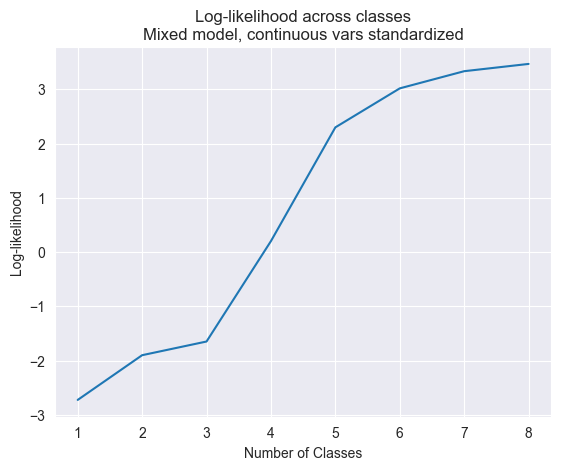

In [10]:
# Higher is better
sns.set_style("darkgrid")
sns.lineplot(data = result_mixed_numcl, 
             x = 'number', 
             y = 'log_likelihood')

# Add labels and title
plt.xlabel('Number of Classes')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood across classes\n' 'Mixed model, continuous vars standardized')

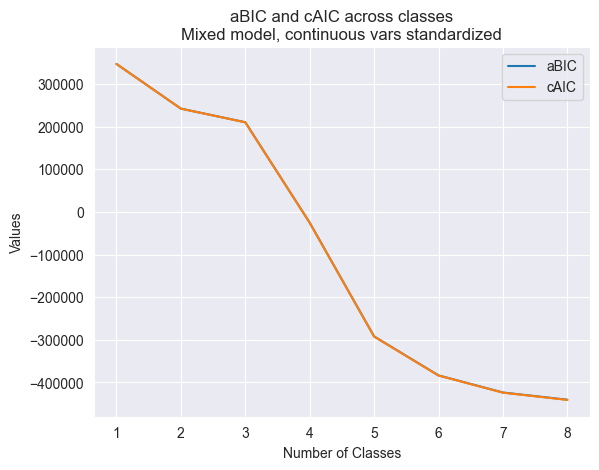

In [11]:
# Lower is better
sns.set_style("darkgrid")
# Create the line plot for ABIC
sns.lineplot(data=result_mixed_numcl, x='number', y='abic', label='aBIC')

# Add another line for CAIC
sns.lineplot(data=result_mixed_numcl, x='number', y='caic', label='cAIC')

# Add labels and title
plt.xlabel('Number of Classes')
plt.ylabel('Values')
plt.title('aBIC and cAIC across classes\n' 'Mixed model, continuous vars standardized')
plt.legend()  # Show the legend to differentiate the lines

# Show the plot
plt.show()

In [98]:
# VALIDATE NUMBER OF COMPONENTS WITH THE BLRT

# Parametric Bootstrapped Likelihood Ratio Test for testing the number of components
# compare a model with  𝑘  components to a model with  𝑘+1  components
# low p-value: k-component model is unlikely model of data compared to k+1 component model
mixed_base3ml = StepMix(
    n_components = 5, 
    n_steps = 3,
    correction = 'ML',
    measurement = mixed_descriptor,   
    verbose = 0, 
    n_init = r,
    max_iter = m,
    random_state = seed)

# Run BLRT sweep from 5 class to 6 classes
# EXPECT SOME CONVERGENCE WARNINGS!
p_val_mixed = blrt_sweep(
    mixed_base3ml, X_mixed, 
    low = 5, 
    high = 7, 
    n_repetitions = 10) # recommended: at least n = 100
p_val_mixed

Testing 5 vs. 6 classes...
Fitting StepMix...


Initializations (n_init) : 100%|███████████████████| 5/5 [00:30<00:00,  6.05s/it, max_LL=1.46e+5, max_avg_LL=2.3]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████| 5/5 [00:11<00:00,  2.32s/it, max_LL=1.92e+5, max_avg_LL=3.02]


Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|█| 10/10 [04:38<00:00, 27.86s/it, max_LL=1.12e+5, median_LL=1.09e+5, min_LL=1.08e



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|█| 10/10 [2:05:07<00:00, 750.74s/it, max_LL=1.12e+5, median_LL=1.09e+5, min_LL=1.


Testing 6 vs. 7 classes...
Fitting StepMix...


Initializations (n_init) : 100%|██████████████████| 5/5 [00:08<00:00,  1.65s/it, max_LL=1.92e+5, max_avg_LL=3.02]


Fitting StepMix...


Initializations (n_init) : 100%|██████████████████| 5/5 [00:07<00:00,  1.53s/it, max_LL=2.12e+5, max_avg_LL=3.34]


Bootstrapping null model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|█| 10/10 [11:20:10<00:00, 4081.04s/it, max_LL=1.5e+5, median_LL=1.49e+5, min_LL=1



Bootstrapping alternative model...

Bootstrapping estimator...


Bootstrap Repetitions    : 100%|█| 10/10 [30:34<00:00, 183.48s/it, max_LL=1.5e+5, median_LL=1.49e+5, min_LL=1.48e


BLRT Sweep Results
                   p
Test                
5 vs. 6 classes  0.0
6 vs. 7 classes  0.0


,p
Test,
5 vs. 6 classes,0.0
6 vs. 7 classes,0.0


In [50]:
# PARAMETERS

mixed_8_3ml = StepMix(
        n_components=8, 
        n_steps=3,
        correction='ML',
        measurement=mixed_descriptor,   
        verbose=1, 
        n_init=r,
        max_iter=m,
        random_state=seed
    )
mixed_8_3ml.fit(X_mixed)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████| 5/5 [00:25<00:00,  5.07s/it, max_LL=2.21e+5, max_avg_LL=3.47]


MODEL REPORT
    Measurement model parameters
          model_name           continuous                                                  
          class_no                      0       1       2    3       4       5    6       7
          param       variable                                                             
          covariances rel_clo      0.0000  0.0000  0.0158  0.0  0.0000  0.0000  0.0  0.0000
                      rel_cnt      0.0182  0.0546  0.0093  0.0  0.0639  0.0244  0.0  0.0294
          means       rel_clo      0.0000  0.5000  0.1313  1.0  0.7500  1.0000  1.0  0.2500
                      rel_cnt      0.0966  0.4368  0.9328  0.8  0.6222  0.4912  1.0  0.2613


          model_name     binary_nan                                                        
          class_no                0       1       2       3       4       5       6       7
          param variable                                                                   
          pis   cnf_lca      0.2

StepMix(correction='ML', max_iter=3000,
        measurement={'binary_nan': {'model': 'binary_nan', 'n_columns': 4},
                     'continuous': {'model': 'continuous', 'n_columns': 2}},
        n_components=8, n_init=5, n_steps=3, random_state=240792, verbose=1)

In [16]:
# Measurement parameters
mm = mixed_8_3ml.get_mm_df()

mm.round(2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stepmix/stepmix.py:1224: FutureWarning: The provided callable <function mean at 0x1047354e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.pivot_table(


class_no                            0     1     2     3     4     5     6  \
model_name param       variable                                             
binary_nan pis         cnf_lca   0.25  0.25  0.73  0.23  0.27  0.18  0.27   
                       mon_lca   0.01  0.05  0.23  0.24  0.13  0.13  0.40   
                       sup_lca   0.04  0.33  0.36  0.83  0.59  0.67  0.92   
                       tra_lca   0.15  0.33  0.79  0.54  0.44  0.37  0.66   
continuous covariances rel_clo   0.00  0.00  0.02  0.00  0.00  0.00  0.00   
                       rel_cnt   0.02  0.05  0.01  0.00  0.06  0.02  0.00   
           means       rel_clo   0.00  0.50  0.13  1.00  0.75  1.00  1.00   
                       rel_cnt   0.10  0.44  0.93  0.80  0.62  0.49  1.00   

class_no                            7  
model_name param       variable        
binary_nan pis         cnf_lca   0.22  
                       mon_lca   0.02  
                       sup_lca   0.11  
                       tra_lca   0.23  
continuous covariances rel_clo   0.00  
                       rel_cnt   0.03  
           means       rel_clo   0.25  
                       rel_cnt   0.26

In [23]:
# 2. Filter out only rows for `pis` (binary variables) and `means` (continuous variables)
# We are assuming that the `variable` column contains the variable names, and the `type` column
# indicates whether it's a "pis" or "means".

# Filter for pis (binary variables)
pis_df = mm[mm.index.get_level_values('param') == 'pis']

# Filter for means (continuous variables)
means_df = mm[mm.index.get_level_values('param') == 'means']

# 3. Concatenate pis and means into a single DataFrame
filtered_df = pd.concat([pis_df, means_df])


# 4. Print or inspect the resulting DataFrame
print(filtered_df)


class_no                          0         1         2         3         4  \
model_name param variable                                                     
binary_nan pis   cnf_lca   0.254169  0.248062  0.732538  0.234758  0.270906   
                 mon_lca   0.006761  0.054842  0.231700  0.235381  0.133347   
                 sup_lca   0.036181  0.328639  0.359518  0.826191  0.594720   
                 tra_lca   0.148107  0.332466  0.792390  0.538672  0.435796   
continuous means rel_clo   0.000000  0.500000  0.131336  1.000000  0.750000   
                 rel_cnt   0.096647  0.436770  0.932816  0.800000  0.622170   

class_no                          5         6         7  
model_name param variable                                
binary_nan pis   cnf_lca   0.178111  0.266119  0.218351  
                 mon_lca   0.125806  0.399794  0.019002  
                 sup_lca   0.665026  0.920467  0.113805  
                 tra_lca   0.369886  0.658380  0.228007  
continuous means re

In [ ]:
# Structural parameters
sm = mixed_8_3ml.get_sm_df()

sm.round(2)

In [80]:
# Class weights
cw = mixed_8_3ml.get_cw_df()

cw.round(2)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stepmix/stepmix.py:613: PerformanceWarning: indexing past lexsort depth may impact performance.
  df = self.get_parameters_df(x_names, y_names).loc[
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stepmix/stepmix.py:1234: FutureWarning: The provided callable <function mean at 0x1047354e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.pivot_table(


class_no,0,1,2,3,4,5,6,7
param,,,,,,,,
class_weights,0.27,0.19,0.01,0.03,0.15,0.04,0.09,0.22


<Axes: xlabel='class_no', ylabel='model_name-param-variable'>

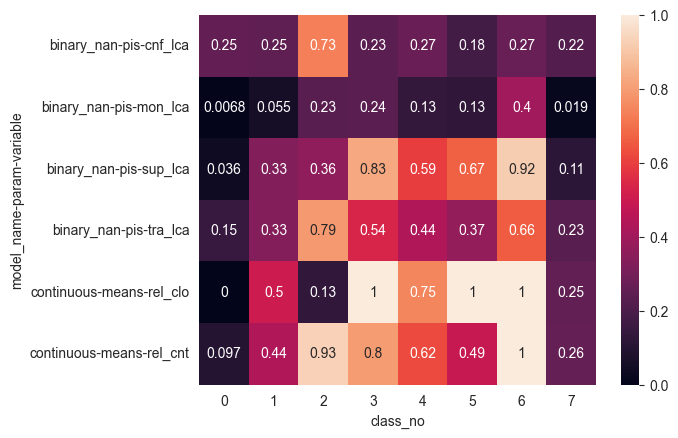

In [24]:
# Measurement parameters (heatmap)
sns.heatmap(filtered_df, annot=True)

In [51]:
# Check the structure of the DataFrame
print(f"Columns (should be the classes): {filtered_df.columns}")
print(f"Index (should be the variables): {filtered_df.index}")

# If the index or columns are tuples, convert them to strings for plotting
filtered_df.columns = filtered_df.columns.map(str)  # Convert column labels (classes) to strings
filtered_df.index = filtered_df.index.map(str)  # Convert index labels (variables) to strings


Columns (should be the classes): Index(['0', '1', '2', '3', '4', '5', '6', '7'], dtype='object', name='class_no')
Index (should be the variables): Index(['('binary_nan', 'pis', 'cnf_lca')', '('binary_nan', 'pis', 'mon_lca')',
       '('binary_nan', 'pis', 'sup_lca')', '('binary_nan', 'pis', 'tra_lca')',
       '('continuous', 'means', 'rel_clo')',
       '('continuous', 'means', 'rel_cnt')'],
      dtype='object')


In [70]:
# GRAPH SETTINGS (order, labels, colors
# (re-use for other class solutions)

# Create a mapping from tuple-based variable names to their new labels
variable_mapping = {
    "('binary_nan', 'pis', 'cnf_lca')": 'Conflict',
    "('binary_nan', 'pis', 'mon_lca')": 'Money',
    "('binary_nan', 'pis', 'sup_lca')": 'Support',
    "('binary_nan', 'pis', 'tra_lca')": 'Proximity',
    "('continuous', 'means', 'rel_clo')": 'Closeness',
    "('continuous', 'means', 'rel_cnt')": 'Contact'
}

# Define the desired order of variables as per the tuples
desired_order = [
    "('binary_nan', 'pis', 'tra_lca')",   # Proximity
    "('continuous', 'means', 'rel_cnt')", # Contact
    "('continuous', 'means', 'rel_clo')", # Closeness
    "('binary_nan', 'pis', 'sup_lca')",   # Support
    "('binary_nan', 'pis', 'mon_lca')",   # Money
    "('binary_nan', 'pis', 'cnf_lca')"    # Conflict
]

# Okabe-Ito color palette (8 colors)
okabe_ito_colors = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]

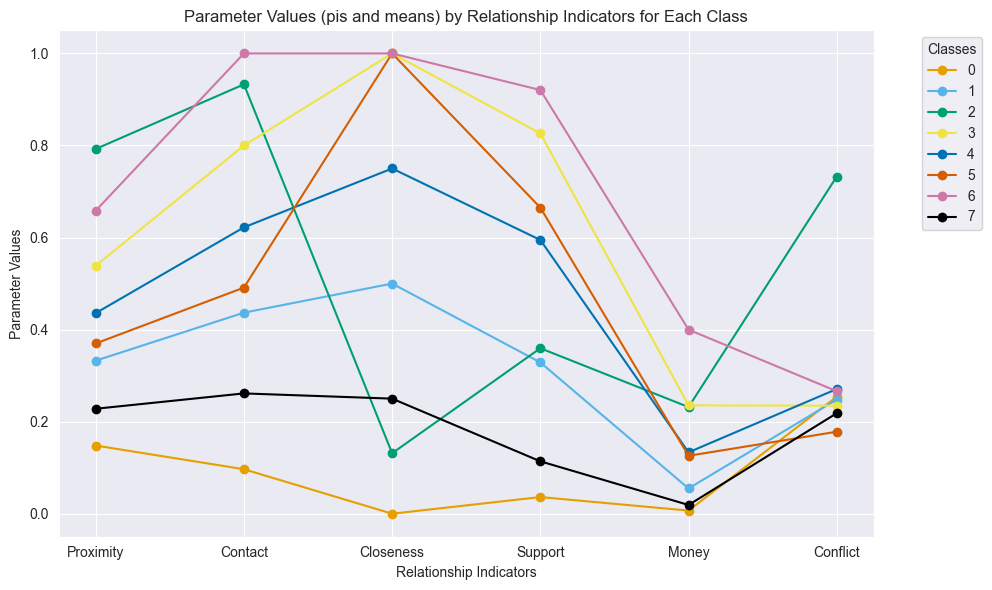

In [84]:
# Reorder the DataFrame based on the actual order of variables
df_plot = filtered_df.loc[desired_order]

# Rename the index (variables) to the new labels using the mapping
df_plot.index = df_plot.index.map(variable_mapping)

# Create a line plot for each class (each column in the DataFrame)
plt.figure(figsize=(10, 6))  # Set figure size

# Plot one line for each class, using the Okabe-Ito color palette
for i, col in enumerate(df_plot.columns):
    plt.plot(df_plot.index, df_plot[col], label=col, marker='o', color=okabe_ito_colors[i % len(okabe_ito_colors)])

# Customize the plot
plt.title('Parameter Values (pis and means) by Relationship Indicators for Each Class')
plt.xlabel('Relationship Indicators')
plt.ylabel('Parameter Values')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability if necessary
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoffs
plt.show()

In [83]:
mixed_7_3ml = StepMix(
        n_components=7, 
        n_steps=3,
        correction='ML',
        measurement=mixed_descriptor,   
        verbose=0, 
        n_init=r,
        max_iter=m,
        random_state=seed
    )
mixed_7_3ml.fit(X_mixed)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████| 5/5 [00:13<00:00,  2.65s/it, max_LL=2.12e+5, max_avg_LL=3.34]

MODEL REPORT
    Measurement model parameters
          model_name           continuous                                             
          class_no                      0    1       2       3       4       5       6
          param       variable                                                        
          covariances rel_clo      0.0000  0.0  0.0000  0.0000  0.0000  0.0158  0.0000
                      rel_cnt      0.0546  0.0  0.0639  0.0371  0.0182  0.0093  0.0294
          means       rel_clo      0.5000  1.0  0.7500  1.0000  0.0000  0.1313  0.2500
                      rel_cnt      0.4368  1.0  0.6222  0.6310  0.0966  0.9328  0.2613


          model_name     binary_nan                                                
          class_no                0       1       2       3       4       5       6
          param variable                                                           
          pis   cnf_lca      0.2481  0.2662  0.2709  0.2037  0.2542  0.7325  0.2184
       

StepMix(correction='ML', max_iter=3000,
        measurement={'binary_nan': {'model': 'binary_nan', 'n_columns': 4},
                     'continuous': {'model': 'continuous', 'n_columns': 2}},
        n_components=7, n_init=5, n_steps=3, random_state=240792, verbose=1)

In [88]:
# 1. Measurement parameters
mm = mixed_7_3ml.get_mm_df()

# 2. Filter out only rows for `pis` (binary variables) and `means` (continuous variables)
# We are assuming that the `variable` column contains the variable names, and the `type` column
# indicates whether it's a "pis" or "means".

# Filter for pis (binary variables)
pis_df = mm[mm.index.get_level_values('param') == 'pis']

# Filter for means (continuous variables)
means_df = mm[mm.index.get_level_values('param') == 'means']

# 3. Concatenate pis and means into a single DataFrame
filtered_df = pd.concat([pis_df, means_df])

# 4. Print or inspect the resulting DataFrame
print(filtered_df)

# Check the structure of the DataFrame
print(f"Columns (should be the classes): {filtered_df.columns}")
print(f"Index (should be the variables): {filtered_df.index}")

# If the index or columns are tuples, convert them to strings for plotting
filtered_df.columns = filtered_df.columns.map(str)  # Convert column labels (classes) to strings
filtered_df.index = filtered_df.index.map(str)  # Convert index labels (variables) to strings


class_no                          0         1         2         3         4  \
model_name param variable                                                     
binary_nan pis   cnf_lca   0.248062  0.266166  0.270906  0.203678  0.254169   
                 mon_lca   0.054842  0.399958  0.133347  0.175250  0.006761   
                 sup_lca   0.328639  0.920608  0.594720  0.737760  0.036181   
                 tra_lca   0.332466  0.658504  0.435796  0.447256  0.148107   
continuous means rel_clo   0.500000  1.000000  0.750000  1.000000  0.000000   
                 rel_cnt   0.436770  1.000000  0.622170  0.630962  0.096647   

class_no                          5         6  
model_name param variable                      
binary_nan pis   cnf_lca   0.732538  0.218351  
                 mon_lca   0.231700  0.019002  
                 sup_lca   0.359518  0.113805  
                 tra_lca   0.792390  0.228007  
continuous means rel_clo   0.131336  0.250000  
                 rel_cnt   0.93

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stepmix/stepmix.py:1224: FutureWarning: The provided callable <function mean at 0x1047354e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.pivot_table(


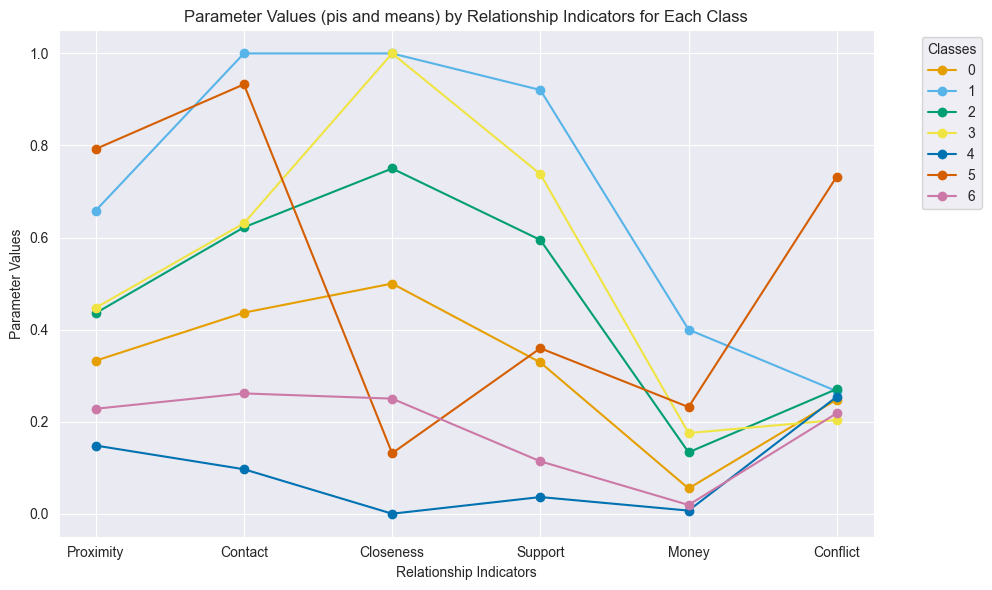

In [89]:
# Reorder the DataFrame based on the actual order of variables
df_plot = filtered_df.loc[desired_order]

# Rename the index (variables) to the new labels using the mapping
df_plot.index = df_plot.index.map(variable_mapping)

# Create a line plot for each class (each column in the DataFrame)
plt.figure(figsize=(10, 6))  # Set figure size

# Plot one line for each class, using the Okabe-Ito color palette
for i, col in enumerate(df_plot.columns):
    plt.plot(df_plot.index, df_plot[col], label=col, marker='o', color=okabe_ito_colors[i % len(okabe_ito_colors)])

# Customize the plot
plt.title('Parameter Values (pis and means) by Relationship Indicators for Each Class')
plt.xlabel('Relationship Indicators')
plt.ylabel('Parameter Values')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability if necessary
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoffs
plt.show()

In [91]:
mixed_6_3ml = StepMix(
        n_components=6, 
        n_steps=3,
        correction='ML',
        measurement=mixed_descriptor,   
        verbose=0, 
        n_init=r,
        max_iter=m,
        random_state=seed
    )
mixed_6_3ml.fit(X_mixed)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████| 5/5 [00:14<00:00,  2.80s/it, max_LL=1.92e+5, max_avg_LL=3.02]


StepMix(correction='ML', max_iter=3000,
        measurement={'binary_nan': {'model': 'binary_nan', 'n_columns': 4},
                     'continuous': {'model': 'continuous', 'n_columns': 2}},
        n_components=6, n_init=5, n_steps=3, random_state=240792)

In [92]:
# 1. Measurement parameters
mm = mixed_6_3ml.get_mm_df()

# 2. Filter out only rows for `pis` (binary variables) and `means` (continuous variables)
# We are assuming that the `variable` column contains the variable names, and the `type` column
# indicates whether it's a "pis" or "means".

# Filter for pis (binary variables)
pis_df = mm[mm.index.get_level_values('param') == 'pis']

# Filter for means (continuous variables)
means_df = mm[mm.index.get_level_values('param') == 'means']

# 3. Concatenate pis and means into a single DataFrame
filtered_df = pd.concat([pis_df, means_df])

# 4. Print or inspect the resulting DataFrame
print(filtered_df)

# Check the structure of the DataFrame
print(f"Columns (should be the classes): {filtered_df.columns}")
print(f"Index (should be the variables): {filtered_df.index}")

# If the index or columns are tuples, convert them to strings for plotting
filtered_df.columns = filtered_df.columns.map(str)  # Convert column labels (classes) to strings
filtered_df.index = filtered_df.index.map(str)  # Convert index labels (variables) to strings

class_no                          0         1         2         3         4  \
model_name param variable                                                     
binary_nan pis   cnf_lca   0.227340  0.248095  0.239951  0.480091  0.221108   
                 mon_lca   0.022748  0.054871  0.305688  0.299659  0.093756   
                 sup_lca   0.118757  0.328659  0.843899  0.782117  0.550109   
                 tra_lca   0.237254  0.332497  0.571160  0.689911  0.373500   
continuous means rel_clo   0.250000  0.500000  1.000000  0.750000  0.750000   
                 rel_cnt   0.271339  0.436797  0.845182  1.000000  0.532225   

class_no                          5  
model_name param variable            
binary_nan pis   cnf_lca   0.257805  
                 mon_lca   0.008514  
                 sup_lca   0.038370  
                 tra_lca   0.155788  
continuous means rel_clo   0.000000  
                 rel_cnt   0.105006  
Columns (should be the classes): Index([0, 1, 2, 3, 4, 5], dtyp

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stepmix/stepmix.py:1224: FutureWarning: The provided callable <function mean at 0x1047354e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.pivot_table(


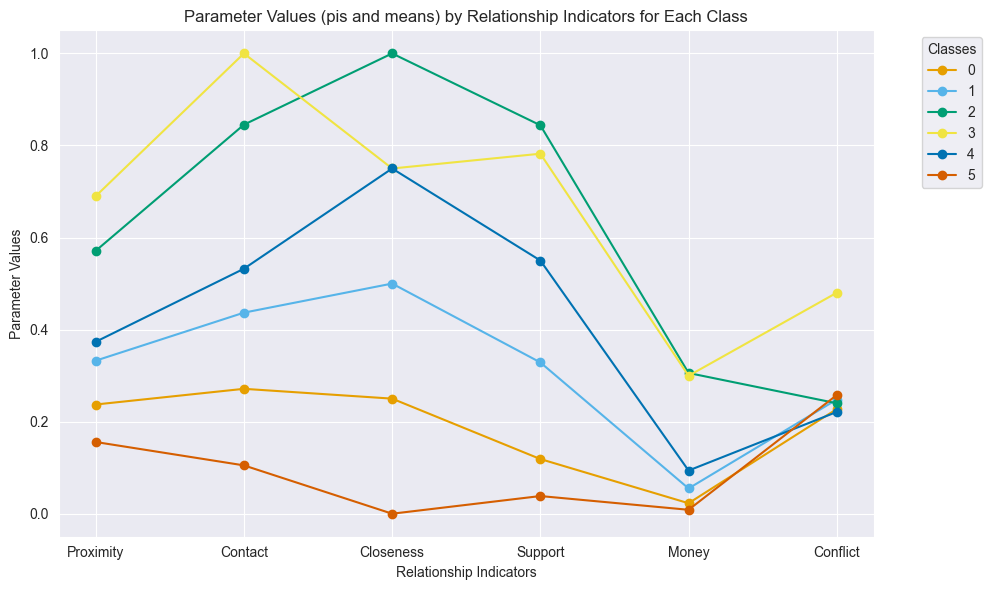

In [93]:
# Reorder the DataFrame based on the actual order of variables
df_plot = filtered_df.loc[desired_order]

# Rename the index (variables) to the new labels using the mapping
df_plot.index = df_plot.index.map(variable_mapping)

# Create a line plot for each class (each column in the DataFrame)
plt.figure(figsize=(10, 6))  # Set figure size

# Plot one line for each class, using the Okabe-Ito color palette
for i, col in enumerate(df_plot.columns):
    plt.plot(df_plot.index, df_plot[col], label=col, marker='o', color=okabe_ito_colors[i % len(okabe_ito_colors)])

# Customize the plot
plt.title('Parameter Values (pis and means) by Relationship Indicators for Each Class')
plt.xlabel('Relationship Indicators')
plt.ylabel('Parameter Values')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability if necessary
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoffs
plt.show()

In [94]:
mixed_5_3ml = StepMix(
        n_components=6, 
        n_steps=3,
        correction='ML',
        measurement=mixed_descriptor,   
        verbose=0, 
        n_init=r,
        max_iter=m,
        random_state=seed
    )
mixed_5_3ml.fit(X_mixed)

Fitting StepMix...


Initializations (n_init) : 100%|██████████████████| 5/5 [00:12<00:00,  2.59s/it, max_LL=1.92e+5, max_avg_LL=3.02]


StepMix(correction='ML', max_iter=3000,
        measurement={'binary_nan': {'model': 'binary_nan', 'n_columns': 4},
                     'continuous': {'model': 'continuous', 'n_columns': 2}},
        n_components=6, n_init=5, n_steps=3, random_state=240792)

In [95]:
# 1. Measurement parameters
mm = mixed_5_3ml.get_mm_df()

# 2. Filter out only rows for `pis` (binary variables) and `means` (continuous variables)
# We are assuming that the `variable` column contains the variable names, and the `type` column
# indicates whether it's a "pis" or "means".

# Filter for pis (binary variables)
pis_df = mm[mm.index.get_level_values('param') == 'pis']

# Filter for means (continuous variables)
means_df = mm[mm.index.get_level_values('param') == 'means']

# 3. Concatenate pis and means into a single DataFrame
filtered_df = pd.concat([pis_df, means_df])

# 4. Print or inspect the resulting DataFrame
print(filtered_df)

# Check the structure of the DataFrame
print(f"Columns (should be the classes): {filtered_df.columns}")
print(f"Index (should be the variables): {filtered_df.index}")

# If the index or columns are tuples, convert them to strings for plotting
filtered_df.columns = filtered_df.columns.map(str)  # Convert column labels (classes) to strings
filtered_df.index = filtered_df.index.map(str)  # Convert index labels (variables) to strings

class_no                          0         1         2         3         4  \
model_name param variable                                                     
binary_nan pis   cnf_lca   0.227340  0.248095  0.239951  0.480091  0.221108   
                 mon_lca   0.022748  0.054871  0.305688  0.299659  0.093756   
                 sup_lca   0.118757  0.328659  0.843899  0.782117  0.550109   
                 tra_lca   0.237254  0.332497  0.571160  0.689911  0.373500   
continuous means rel_clo   0.250000  0.500000  1.000000  0.750000  0.750000   
                 rel_cnt   0.271339  0.436797  0.845182  1.000000  0.532225   

class_no                          5  
model_name param variable            
binary_nan pis   cnf_lca   0.257805  
                 mon_lca   0.008514  
                 sup_lca   0.038370  
                 tra_lca   0.155788  
continuous means rel_clo   0.000000  
                 rel_cnt   0.105006  
Columns (should be the classes): Index([0, 1, 2, 3, 4, 5], dtyp

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/stepmix/stepmix.py:1224: FutureWarning: The provided callable <function mean at 0x1047354e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  return pd.pivot_table(


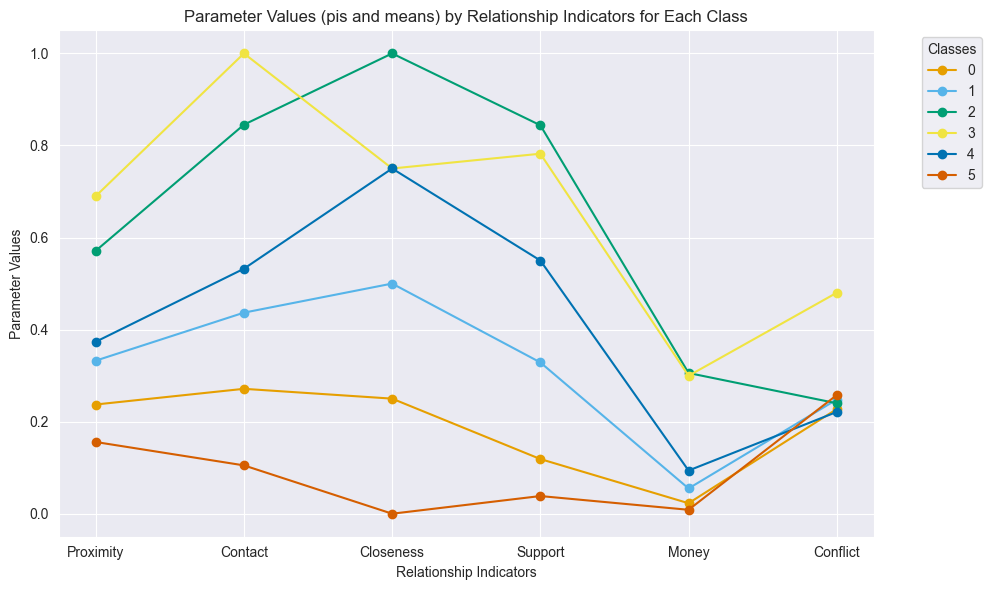

In [96]:
# Reorder the DataFrame based on the actual order of variables
df_plot = filtered_df.loc[desired_order]

# Rename the index (variables) to the new labels using the mapping
df_plot.index = df_plot.index.map(variable_mapping)

# Create a line plot for each class (each column in the DataFrame)
plt.figure(figsize=(10, 6))  # Set figure size

# Plot one line for each class, using the Okabe-Ito color palette
for i, col in enumerate(df_plot.columns):
    plt.plot(df_plot.index, df_plot[col], label=col, marker='o', color=okabe_ito_colors[i % len(okabe_ito_colors)])

# Customize the plot
plt.title('Parameter Values (pis and means) by Relationship Indicators for Each Class')
plt.xlabel('Relationship Indicators')
plt.ylabel('Parameter Values')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability if necessary
plt.legend(title='Classes', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot

# Show the plot
plt.tight_layout()  # Adjust layout to prevent label cutoffs
plt.show()

In [97]:
X_mixed

,rel_cnt,rel_clo,tra_lca,cnf_lca,sup_lca,mon_lca
1,1.0,1.00,1.0,0,1,1
2,1.0,1.00,1.0,0,1,1
3,0.6,0.75,1.0,0,0,0
4,0.8,0.75,0.0,0,0,0
5,0.8,1.00,1.0,0,1,1
...,...,...,...,...,...,...
63668,0.8,0.75,0.0,1,0,0
63669,0.8,0.75,0.0,1,0,0
63670,0.8,0.75,0.0,1,1,1
63671,0.8,0.75,0.0,1,1,0
